In [1]:
# =========================================
# 0) Kurulum & Kütüphaneler
# =========================================
# Colab için
from google.colab import drive
drive.mount('/content/drive')

!pip -q install rasterio laspy lxml


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 6.2 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import os, json, math
import numpy as np
import pandas as pd
import rasterio
import laspy
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (3D plot aktivasyonu)

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True


In [3]:
# =========================================
# 1) Yol Ayarları ve Yardımcılar
# =========================================
BASE_DIR = Path("/content/drive/MyDrive/weecology-NeonTreeEvaluation-d0b90bc")
EVAL_DIR = BASE_DIR / "evaluation"

RGB_DIR   = EVAL_DIR / "RGB"
HSI_DIR   = EVAL_DIR / "Hyperspectral"
CHM_DIR   = EVAL_DIR / "CHM"
LIDAR_DIR = EVAL_DIR / "LiDAR"
ANNOT_DIR = BASE_DIR / "annotations"

# Örnek tek karo (isterseniz değiştirin)
sample_rgb   = RGB_DIR   / "2018_SJER_3_252000_4106000_image_66.tif"
sample_hsi   = HSI_DIR   / "2018_SJER_3_252000_4106000_image_66_hyperspectral.tif"
sample_chm   = CHM_DIR   / "2018_SJER_3_252000_4106000_image_66_CHM.tif"
sample_lidar = LIDAR_DIR / "2018_SJER_3_252000_4106000_image_66.laz"

# HSI dalga boyu ekseni (NEON: ~426 bant, 350-2500 nm aralığı varsayımı)
with rasterio.open(sample_hsi) as src:
    N_BANDS = src.count
WAVELENGTHS = np.linspace(350, 2500, N_BANDS)

# Gürültülü su emilim pencerelerini görselde işaretlemek için
NOISY_WINDOWS = [(1340, 1460), (1830, 1960)]

def band_idx_for_nm(nm: float) -> int:
    """Verilen dalgaboyuna en yakın HSI bandının 1-based indeksini döndürür."""
    return int(np.argmin(np.abs(WAVELENGTHS - nm))) + 1

def shade_noisy_windows(ax):
    for (a, b) in NOISY_WINDOWS:
        ax.axvspan(a, b, alpha=0.12, color='gray')

def safe_clip_box(box, width, height):
    xmin, ymin, xmax, ymax = box
    xmin = max(0, min(int(round(xmin)), width  - 1))
    xmax = max(0, min(int(round(xmax)), width  - 1))
    ymin = max(0, min(int(round(ymin)), height - 1))
    ymax = max(0, min(int(round(ymax)), height - 1))
    if xmax <= xmin or ymax <= ymin:
        return None
    return (xmin, ymin, xmax, ymax)

def poly_slope(x, y):
    if len(x) < 2:
        return np.nan
    return np.polyfit(x, y, 1)[0]


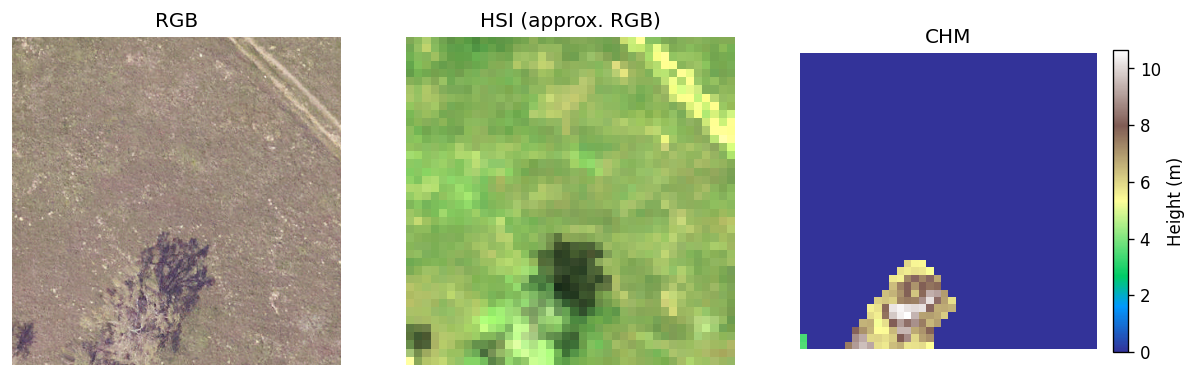

In [4]:
# =========================================
# 2) Hızlı Panel: RGB • HSI(~RGB) • CHM
# =========================================
def quick_panels(rgb_path: Path, hsi_path: Path, chm_path: Path):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # RGB
    with rasterio.open(rgb_path) as src:
        rgb = np.transpose(src.read([1,2,3]), (1,2,0))
    axs[0].imshow(rgb)
    axs[0].set_title("RGB"); axs[0].axis('off')

    # HSI -> yaklaşık RGB
    with rasterio.open(hsi_path) as src:
        r = src.read(band_idx_for_nm(650))
        g = src.read(band_idx_for_nm(550))
        b = src.read(band_idx_for_nm(450))
        stack = np.stack([r, g, b], axis=-1).astype(np.float32)
        stack /= np.percentile(stack, 99) + 1e-9  # kaba normalize
        stack = np.clip(stack, 0, 1)
    axs[1].imshow(stack)
    axs[1].set_title("HSI (approx. RGB)"); axs[1].axis('off')

    # CHM
    with rasterio.open(chm_path) as src:
        chm = src.read(1).astype(np.float32)
        chm[chm < 0] = np.nan
    im = axs[2].imshow(chm, cmap='terrain')
    axs[2].set_title("CHM"); axs[2].axis('off')
    cbar = fig.colorbar(im, ax=axs[2], fraction=0.046)
    cbar.set_label("Height (m)")
    plt.show()

quick_panels(sample_rgb, sample_hsi, sample_chm)


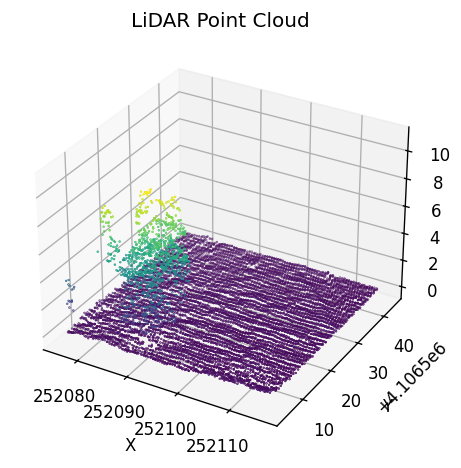

In [5]:
# =========================================
# 3) LiDAR 3B Nokta Bulutu (matplotlib)
# =========================================
def read_lidar_points(laz_path: Path) -> np.ndarray:
    las = laspy.read(str(laz_path))        # context manager kullanmıyoruz
    pts = np.vstack([las.x, las.y, las.z]).T
    return pts

def plot_lidar_3d(laz_path: Path, max_points=200_000):
    pts = read_lidar_points(laz_path)
    if len(pts) > max_points:
        idx = np.random.choice(len(pts), size=max_points, replace=False)
        pts = pts[idx]

    fig = plt.figure(figsize=(4.5, 4.5))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=0.1, c=pts[:,2])
    ax.set_title("LiDAR Point Cloud")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.show()

plot_lidar_3d(sample_lidar, max_points=100_000)


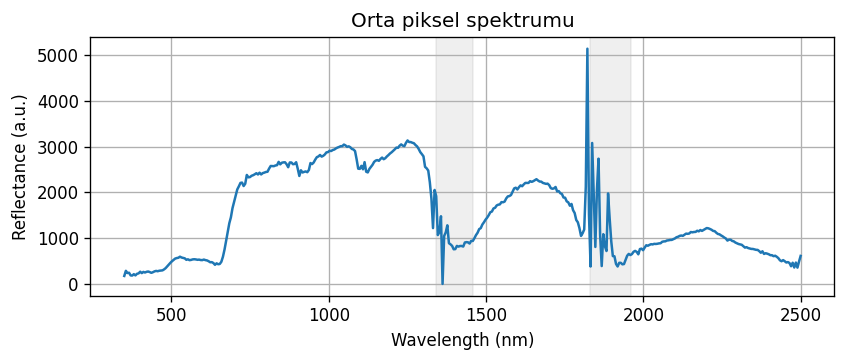

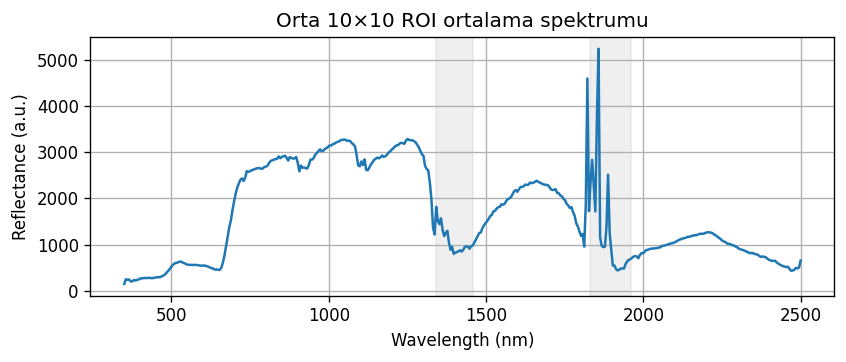

In [6]:
# =========================================
# 4) Piksel ve ROI Spektrumları
# =========================================
def plot_pixel_spectrum(hsi_path: Path, row: int, col: int, title="Pixel spectrum"):
    with rasterio.open(hsi_path) as src:
        H, W = src.height, src.width
        if not (0 <= row < H and 0 <= col < W):
            raise ValueError(f"({row},{col}) geçersiz, aralık: row[0,{H-1}], col[0,{W-1}]")
        spec = src.read()[:, row, col]

    fig, ax = plt.subplots(1, 1, figsize=(8, 2.8))
    ax.plot(WAVELENGTHS, spec)
    shade_noisy_windows(ax)
    ax.set_title(title)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Reflectance (a.u.)")
    plt.show()

def plot_roi_spectrum(hsi_path: Path, r0, r1, c0, c1, title="ROI mean spectrum"):
    with rasterio.open(hsi_path) as src:
        H,W = src.height, src.width
        if not (0 <= r0 < r1 <= H and 0 <= c0 < c1 <= W):
            raise ValueError(f"ROI geçersiz. H={H}, W={W}")
        roi = src.read()[:, r0:r1, c0:c1]
        spec = roi.mean(axis=(1,2))

    fig, ax = plt.subplots(1, 1, figsize=(8, 2.8))
    ax.plot(WAVELENGTHS, spec)
    shade_noisy_windows(ax)
    ax.set_title(title)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Reflectance (a.u.)")
    plt.show()

# örnek kullanım
plot_pixel_spectrum(sample_hsi, 20, 20, title="Orta piksel spektrumu")
plot_roi_spectrum(sample_hsi, 15, 25, 15, 25, title="Orta 10×10 ROI ortalama spektrumu")


In [7]:
# =========================================
# 5) XML -> HSI Ölçekli Kutular & Tür Bazlı İmzalar
# =========================================
def find_rgb_hsi_for_xml(stem: str):
    """XML adı gövdesine (stem) göre uygun RGB ve HSI dosyalarını bulur."""
    # Öncelik: tam içeren
    cand_hsi = [p for p in HSI_DIR.glob("*.tif") if stem in p.name and "hyperspectral" in p.name]
    cand_rgb = [p for p in RGB_DIR.glob("*.tif") if stem in p.name]
    # Plan B: 'hyperspectral' koşulu gevşet
    if not cand_hsi:
        cand_hsi = [p for p in HSI_DIR.glob("*.tif") if stem in p.name]
    if cand_hsi and cand_rgb:
        return cand_rgb[0], cand_hsi[0]
    return None, None

def parse_scaled_boxes(xml_path: Path, rgb_path: Path, hsi_path: Path, min_size: int = 3):
    """XML kutularını RGB->HSI ölçekleyip HSI sınırlarına klipler. Çok küçük kutuları eler."""
    with rasterio.open(rgb_path) as rgb:
        rgb_h, rgb_w = rgb.height, rgb.width
    with rasterio.open(hsi_path) as hsi:
        hsi_h, hsi_w = hsi.height, hsi.width

    sx = hsi_w / rgb_w
    sy = hsi_h / rgb_h

    root = ET.parse(xml_path).getroot()
    items = []
    for obj in root.findall("object"):
        label = (obj.findtext("name") or "Unknown").strip()
        bb = obj.find("bndbox")
        xmin = float(bb.findtext("xmin")); ymin = float(bb.findtext("ymin"))
        xmax = float(bb.findtext("xmax")); ymax = float(bb.findtext("ymax"))
        # Ölçekle
        xmin, xmax = xmin * sx, xmax * sx
        ymin, ymax = ymin * sy, ymax * sy
        # Kliple
        clipped = safe_clip_box((xmin, ymin, xmax, ymax), hsi_w, hsi_h)
        if clipped is None:
            continue
        cxmin, cymin, cxmax, cymax = clipped
        if (cxmax - cxmin) < min_size or (cymax - cymin) < min_size:
            continue
        items.append({"label": label, "box": (cxmin, cymin, cxmax, cymax)})
    return items

def species_signatures_from_xml(xml_paths, max_rois_per_species=20, min_size=3):
    """Birden çok XML'den tür-bazlı μ±σ spektral imzası üretir."""
    species_specs = {}     # label -> list of ROI mean spectra
    used_counts  = {}      # takip için

    for xml_path in xml_paths:
        stem = Path(xml_path).stem
        rgb_path, hsi_path = find_rgb_hsi_for_xml(stem)
        if (rgb_path is None) or (hsi_path is None):
            # SJER gibi uzun isimlerde farklı eşleşme: XML tam adı HSI içinde zaten olabilir
            # Yine de eşleşme bulunmadıysa atla
            continue

        # Kutuları ölçekle
        boxes = parse_scaled_boxes(Path(xml_path), rgb_path, hsi_path, min_size=min_size)
        if not boxes:
            continue

        with rasterio.open(hsi_path) as src:
            cube = src.read()  # [B,H,W]
        for it in boxes:
            label = it["label"]
            used_counts.setdefault(label, 0)
            if used_counts[label] >= max_rois_per_species:
                continue
            x0,y0,x1,y1 = it["box"]
            roi = cube[:, y0:y1, x0:x1]
            if roi.size == 0:
                continue
            mean_spec = roi.mean(axis=(1,2))
            species_specs.setdefault(label, []).append(mean_spec)
            used_counts[label] += 1

    # μ, σ hesapla
    signatures = {}
    for label, arr_list in species_specs.items():
        stack = np.stack(arr_list, axis=0)  # [N, B]
        mu = np.nanmean(stack, axis=0)
        sd = np.nanstd(stack, axis=0)
        signatures[label] = {"mu": mu, "sd": sd, "n": stack.shape[0]}
    return signatures

def plot_species_signatures(signatures, title="Anotasyonlardan Tür Bazlı Spektral İmzalar (mean ± std)"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4.2))
    for label, d in signatures.items():
        mu, sd, n = d["mu"], d["sd"], d["n"]
        ax.plot(WAVELENGTHS, mu, label=f"{label} (n={n})")
        ax.fill_between(WAVELENGTHS, mu - sd, mu + sd, alpha=0.2)
    shade_noisy_windows(ax)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Reflectance (a.u.)")
    ax.set_title(title)
    ax.legend()
    plt.show()

def metrics_for_signature(mu):
    """NDVI ve red-edge eğimi (680-740 nm lineer fit)"""
    red  = mu[band_idx_for_nm(650)-1]
    nir  = mu[band_idx_for_nm(850)-1]
    ndvi = (nir - red) / (nir + red + 1e-9)

    mask = (WAVELENGTHS >= 680) & (WAVELENGTHS <= 740)
    slope = poly_slope(WAVELENGTHS[mask], mu[mask])
    return ndvi, slope

def save_signatures_csv(signatures, out_csv: Path):
    """(tür, bant_nm, mu, sd, n) biçiminde CSV kaydeder."""
    rows = []
    for label, d in signatures.items():
        mu, sd, n = d["mu"], d["sd"], d["n"]
        for wl, m, s in zip(WAVELENGTHS, mu, sd):
            rows.append({"species": label, "wavelength_nm": float(wl),
                         "mu": float(m), "sd": float(s), "n": int(n)})
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    return out_csv


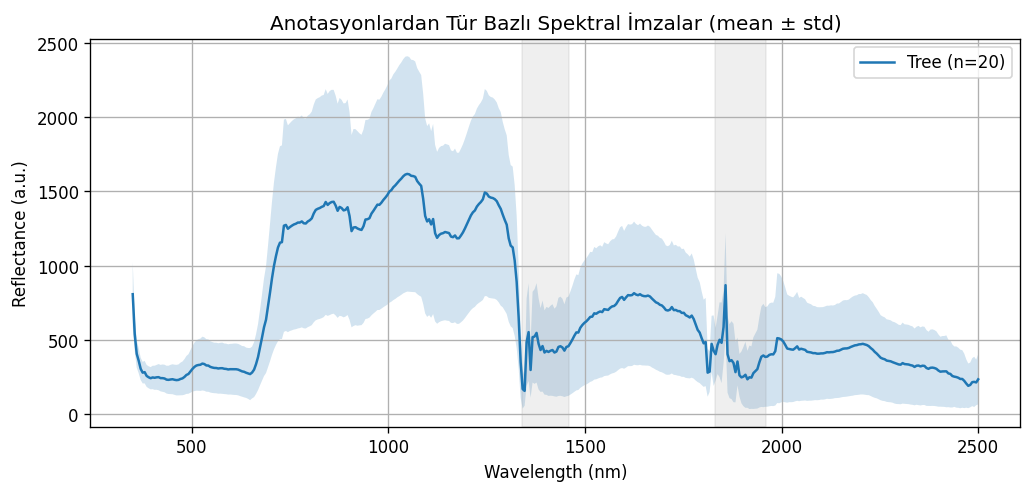

== Kısa Sayısal Özet ==
 • Tree         | NDVI≈0.680 | Red‑edge slope≈12.8972 | n=20


In [8]:
# =========================================
# 6) Tür İmzalarını Üret ve Çiz (seçili XML listesi veya tümü)
# =========================================
# Küçük bir örnek: ilk 5 XML
xml_list = sorted([str(p) for p in ANNOT_DIR.glob("*.xml")])[:5]

signatures = species_signatures_from_xml(
    xml_list,
    max_rois_per_species=20,   # tür başına en çok 20 ROI kullan
    min_size=3                 # 3x3'ten küçük kutuları ele
)

plot_species_signatures(signatures)

# Kısa metrik özeti
print("== Kısa Sayısal Özet ==")
for label, d in signatures.items():
    ndvi, slope = metrics_for_signature(d["mu"])
    print(f" • {label:<12} | NDVI≈{ndvi:.3f} | Red‑edge slope≈{slope:.4f} | n={d['n']}")

# CSV'ye kaydetmek için
# csv_path = BASE_DIR / "species_signatures_demo.csv"
# save_signatures_csv(signatures, csv_path)
# print("CSV kaydedildi:", csv_path)
